In [1]:
from outriggers_vlbi_pipeline.query_database import (
    fetch_data_from_sheet,
    write_dataframe_to_sheet,
    find_files,
    get_full_filepath,get_calibrator_dataframe,
)
import pandas
from outriggers_vlbi_pipeline.calibrator_search.find_fringes import get_all_event_ids
import numpy as np
from glob import glob


import matplotlib.pyplot as plt
MPLSTYLE = '/arc/home/shiona/paper_sty.mplstyle'
plt.style.use(MPLSTYLE)

journal_textwidths = {'prd': 6.50127,
                      'none': 8.5,
                      'kaobook':6.5, # just a guess
                      'apj':6.0,
                      'aj': 6.0
                      } # Latex's \textwidth in inches

def figsize(fraction_of_textwidth = 0.45,height_per_width  = 1 / 1.61803399,journal = 'prd'):
    """When making your figure, decide its aspect ratio and your journal and its width as a fraction of the \textwidth of the journal. Then use matplotlib.pyplot.Figure(figsize = ...) to specify the right size"""
    textwidth = journal_textwidths[journal]
    width_in = textwidth * fraction_of_textwidth
    height_in = height_per_width * width_in
    return (width_in, height_in)

plt.rcParams["figure.figsize"] = figsize( 2 / 1.61803399,journal = 'apj')



In [2]:
df=get_calibrator_dataframe()

tel='gbo'
detection_df_gbo=get_all_event_ids(df,tel2=tel)
tel='hco'
detection_df_hco=get_all_event_ids(df,tel2=tel)
detection_df_hco['snr'] = pandas.to_numeric(detection_df_hco['snr'], errors='coerce')
detection_df_gbo['snr'] = pandas.to_numeric(detection_df_gbo['snr'], errors='coerce')

detection_df_hco=detection_df_hco[detection_df_hco['snr']>30].reset_index(drop=True)
detection_df_gbo=detection_df_gbo[detection_df_gbo['snr']>30].reset_index(drop=True)


In [3]:
gbo_ids=[]
for i in detection_df_gbo['event_id'].value_counts()[:30].items():
    if i[0]>10:
        eid=i[0]
        if len(glob(f'/arc/projects/chime_frb/vlbi/hco*/*/*/*/{eid}'))==0:
            print(f'eid not found {eid}')
        else:
            gbo_ids.append(eid)

hco_ids=[]
for i in detection_df_hco['event_id'].value_counts()[:30].items():
    if type(i[0])!=str:
        if i[0]>10:
            eid=i[0]
            if len(glob(f'/arc/projects/chime_frb/vlbi/hco*/*/*/*/{eid}'))==0:
                print(f'eid not found {eid}')
            else:
                hco_ids.append(i[0])



eid not found 20250418054922
eid not found 20260122095246
eid not found 20250417054519
eid not found 20250317073115
eid not found 20250516040716
eid not found 20231022044215
eid not found 20250509042648
eid not found 20250417054519
eid not found 20250418054922
eid not found 20250516040716
eid not found 20250509042648


In [4]:
gbo_out_df=pandas.DataFrame(gbo_ids,columns=['event_id'])
gbo_out_df.to_csv(f'gbo_bl_offset_eids.csv')
hco_out_df=pandas.DataFrame(hco_ids,columns=['event_id'])
hco_out_df.to_csv(f'hco_bl_offset_eids.csv')

In [118]:
hco_out_df

,event_id
0,436928449
1,438535323
2,440021683
3,441021463
4,1123860224
5,1122984830
6,1138026090
7,1128103969
8,1137928820
9,1122225474


## to start, let's just do this with one event id manually to see if we believe (1) the calibration (2) the fringefit (3) the fringe fit across pairs

In [ ]:
from outriggers_vlbi_pipeline.calibration import fft_fringefit
import coda
from outriggers_vlbi_pipeline.calibration import create_calibrated_visibilities,fringefit,fft_fringefit
from coda.core import VLBIVis
import os
event_id=436928449
SNR_THRESH=30
detection_df=detection_df_hco
tel='hco'
baseline_name=f'chime-{tel}'

dfx=detection_df[detection_df['event_id']==event_id].reset_index(drop=True)
dfx=dfx[dfx['snr']>SNR_THRESH]
dfx=dfx.sort_values(by='snr',ascending=False).reset_index(drop=True)

tag='trial1'

input_dir=f'/arc/projects/chime_frb/vlbi/hco*rfi*/*/*/*/{event_id}/calibrator_visibilities/'
out_dir=f'/arc/projects/chime_frb/vlbi/OVP_astrometry_{tel}_F11/{tag}/{event_id}/calibrated/'
os.makedirs(out_dir,exist_ok=True)

sources=(dfx['name'])

tec_grid = np.arange(-40,40,.1)

for i in range(len(sources)-1):
    bright_cal=sources[i]
    #print(bright_cal)
    #print(f"{input_dir}*{bright_cal}*")
    calibrator_file=glob(f"{input_dir}*{bright_cal}*")[0]
    cal_vis=VLBIVis.from_file(calibrator_file)
    coda.analysis.flagging.get_optimal_rfi_mask(cal_vis[baseline_name],write=True,sub_integration_scan=0)
    target_files=[]
    for source in sources[i+1:]:
        target_files.append(glob(f"{input_dir}*{source}*")[0])
        
        for tar_file in target_files:
            vis_target=VLBIVis.from_file(tar_file)
            coda.analysis.flagging.get_optimal_rfi_mask(vis_target[baseline_name],write=True,sub_integration_scan=0)
            create_calibrated_visibilities([cal_vis],vis_target,out_dir=out_dir)
    print('done calibrating')
    calibrated_files=glob(f'{out_dir}*')
    print(calibrated_files)
    for file in calibrated_files:
        vis=VLBIVis.from_file(file)
        if 'tecs' not in vis[f'chime-{tel}']['vis'].attrs.keys():
            fringefit(vis[f'chime-{tel}'],tec_grid=tec_grid)
            vis.save(file)
            
        if 'fft_taus' not in vis[f'chime-{tel}'].attrs.keys():
            fft_fringefit(vis[f'chime-{tel}'],tec_grid)
            vis.save(file)


## Now, let's manually inspect (1) the calibration (2) the fringefit (3) the fringe fit across pairs. 


In [34]:
## to start, let's just do this with one event id manually to see if we believe (1) the calibration (2) the fringefit (3) the fringe fit across pairs

In [3]:
from beam_model.utils import get_position_from_equatorial,get_equatorial_from_position

def get_beam(vis_target,baseline_name):
    ctime = np.nanmedian(vis_target['chime']['gate']['gate_start_unix'])
    x_deg, y_deg = get_position_from_equatorial(vis_target.ra[0], vis_target.dec[0],ctime)
    vis_target[baseline_name]['vis'].attrs['x_deg']=x_deg
    vis_target[baseline_name]['vis'].attrs['y_deg']=y_deg

    x_deg, y_deg = get_position_from_equatorial(vis_target[baseline_name]['calibrator_ra'][0], 
                                                vis_target[baseline_name]['calibrator_dec'],ctime)

    vis_target[baseline_name]['vis'].attrs['cal_x_deg']=x_deg
    vis_target[baseline_name]['vis'].attrs['cal_y_deg']=y_deg
    vis_target[baseline_name]['vis'].attrs['time']=ctime
    vis_target[baseline_name]['vis'].attrs['cal_ra']=vis_target[baseline_name]['calibrator_ra'][0]
    vis_target[baseline_name]['vis'].attrs['cal_dec']=vis_target[baseline_name]['calibrator_dec'][0]
    vis_target[baseline_name]['vis'].attrs['ra']=vis_target.ra[0]
    vis_target[baseline_name]['vis'].attrs['dec']=vis_target.dec[0]
    
    return

In [99]:
#get_beam(vis,baseline_name)
#df.loc[df['file']==file,'calibrator_source_name']='X'
df['calibrator_source_name']

0      J1127+5743
1      J1129+5638
2      J1127+5743
3      J1132+6324
4      J1129+5025
          ...    
115    J1130+3815
116    J1132+6324
117    J1130+2157
118    J1129+5025
119    J1127+5650
Name: calibrator_source_name, Length: 120, dtype: object

In [7]:
df

,file,fft_taus_xx,fft_taus_yy,fft_tecs_xx,fft_tecs_yy,taus_xx,taus_yy,tecs_xx,tecs_yy,taus_no_iono_xx,...,y_deg,cal_x_deg,cal_y_deg,cal_dec,cal_ra,dec,ra,time,name,calibrator_source_name
0,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,/arc/projects/chime_frb/vlbi/OVP_astrometry_hc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from coda.core import VLBIVis

tag=''
out_dir=f'/arc/projects/chime_frb/vlbi/OVP_astrometry_{tel}_F11/trial1/*/calibrated/'
calibrated_files=glob(f'{out_dir}*')
df=pandas.DataFrame(calibrated_files,columns=['file'])

keys=['fft_taus','fft_tecs','taus','tecs','taus_no_iono']

for key in keys:
    df[f'{key}_xx']=0.0
    df[f'{key}_yy']=0.0

pos_keys=['x_deg','y_deg','cal_x_deg','cal_y_deg','cal_dec','cal_ra','dec','ra','time']
    
for key in pos_keys:
    df[f'{key}']=0.0

name_keys=['name','calibrator_source_name']
for key in name_keys:
    df[f'{key}']=0.0
    
for i,file in enumerate(calibrated_files):
    try:
        vis=VLBIVis.from_file(file)
        vis_bl=vis[f'chime-{tel}']
        get_beam(vis,f'chime-{tel}')
        for key in keys:
            df.loc[df['file']==file,f'{key}_xx']=vis_bl['vis'].attrs[f'{key}{tag}'][0]
            df.loc[df['file']==file,f'{key}_yy']=vis_bl['vis'].attrs[f'{key}{tag}'][1]

        for key in pos_keys:
            df.loc[df['file']==file,key]=vis_bl['vis'].attrs[key]
        df.loc[df['file']==file,'calibrator_source_name']=vis_bl['calibrator_source_name'][0].astype(str)
        df.loc[df['file']==file,'name']=vis.source_name[0].astype(str)

    except Exception as e:
        print(f'not found {file} {e}')


not found /arc/projects/chime_frb/vlbi/OVP_astrometry_hco_F11/trial1/441021463/calibrated/J1140+5912_calibrated_to_J1137+3950_vis.h5 'fft_taus'


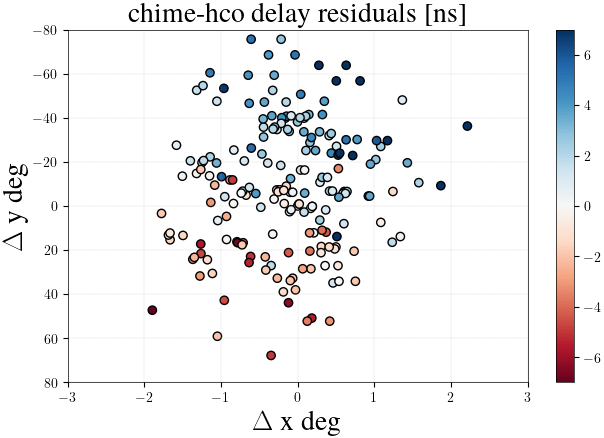

In [12]:
#pos_keys=['x_deg','y_deg','cal_x_deg','cal_y_deg']
fontsize=20
im=plt.scatter(df['x_deg']-df['cal_x_deg'],df['y_deg']-df['cal_y_deg'],c=df['taus_xx']*1e3,edgecolor='black',cmap='RdBu',vmin=-7,vmax=7)
plt.colorbar(im)
plt.ylim(80,-80)
plt.xlim(-3,3)
plt.title(f'chime-{tel} delay residuals [ns]')
plt.xlabel(r'$\Delta$ x deg',fontsize=fontsize)
plt.ylabel(r'$\Delta$ y deg',fontsize=fontsize)
plt.show()

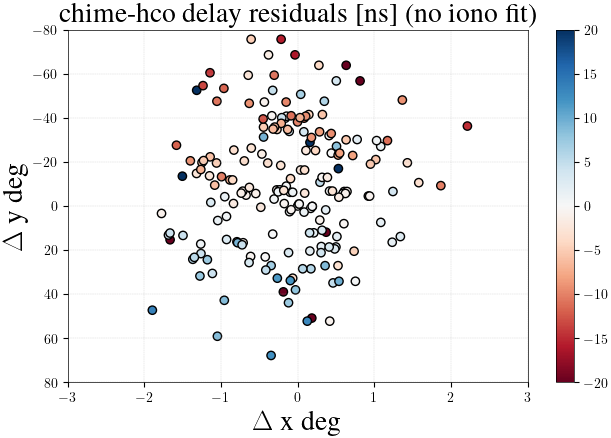

In [13]:
im=plt.scatter(df['x_deg']-df['cal_x_deg'],df['y_deg']-df['cal_y_deg'],c=df['taus_no_iono_xx']*1e3,edgecolor='black',cmap='RdBu',vmin=-20,vmax=20)
plt.colorbar(im)
plt.ylim(80,-80)
plt.xlim(-3,3)
plt.title(f'chime-{tel} delay residuals [ns] (no iono fit)')
plt.xlabel(r'$\Delta$ x deg',fontsize=fontsize)
plt.ylabel(r'$\Delta$ y deg',fontsize=fontsize)
plt.show()

In [14]:
from outriggers_vlbi_pipeline.vlbi_pipeline_config import chime,hco,gbo

from astropy.coordinates import SkyCoord, EarthLocation, ITRS
from astropy.time import Time
import astropy.units as u
import numpy as np

# 1) Telescopes in meters (geocentric ITRF XYZ)
r1 = chime
r2 = hco

def get_projection(raA,raB,decA,decB,unix_time):
    # 2) Source coordinates
    
    A = SkyCoord(ra=raA*u.deg, dec=decA*u.deg)
    B = SkyCoord(ra=raB*u.deg, dec=decB*u.deg)

    # 3) Convert to ITRF at the observation time
    t = Time(unix_time, format='unix')

    A_itrs = A.transform_to(ITRS(obstime=t))
    B_itrs = B.transform_to(ITRS(obstime=t))
    # Unit vectors in ITRF
    sA = np.array([A_itrs.x.value, A_itrs.y.value, A_itrs.z.value])
    sB = np.array([B_itrs.x.value, B_itrs.y.value, B_itrs.z.value])

    sA /= np.linalg.norm(sA)
    sB /= np.linalg.norm(sB)

    # 4) Baseline vector
    #b = np.array(r2.geocentric) - np.array(r1.geocentric)  # meters
    #b = np.array(b, dtype=float)
    b = np.array([r2.x.value - r1.x.value,
         r2.y.value - r1.y.value,
         r2.z.value - r1.z.value]) 

    # 5) Projection of A–B onto baseline
    projection = b*(sA - sB)/np.linalg.norm(b)  # meters
    return projection


In [15]:
i=0
projectionsx=[]
projectionsy=[]
projectionsz=[]
for i in range(len(df)):
    projections=get_projection(df['ra'][i],df['cal_ra'][i],df['dec'][i],df['cal_dec'][i],df['time'][i])
    projectionsx.append(projections[0])
    projectionsy.append(projections[1])
    projectionsz.append(projections[2])

[2026-02-13 18:55:47,655] WARNING Tried to get polar motions for times before IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the arcsec level. Please check your astropy.utils.iers.conf.iers_auto_url and point it to a newer version if necessary.


In [16]:
df['projectionsx']=projectionsx
df['projectionsy']=projectionsy
df['projectionsz']=projectionsz


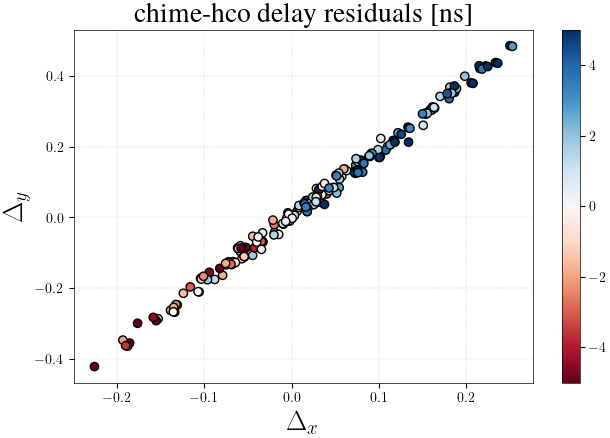

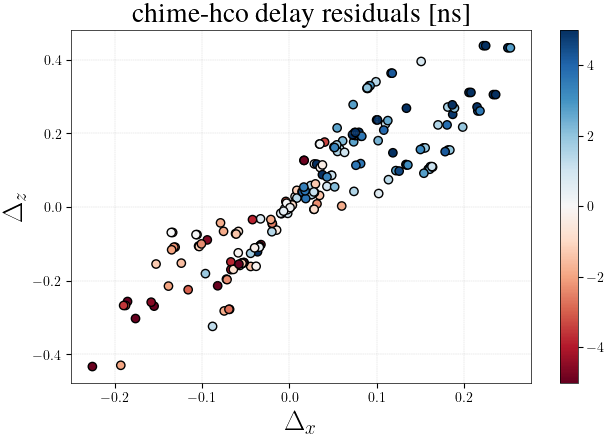

In [17]:
im=plt.scatter(df['projectionsx'],df['projectionsy'],c=df['taus_xx']*1e3,edgecolor='black',cmap='RdBu',vmin=-5,vmax=5)
plt.colorbar(im)
plt.title(f'chime-{tel} delay residuals [ns] ')
plt.xlabel(r'${\Delta}_x$',fontsize=fontsize)
plt.ylabel(r'${\Delta}_y$',fontsize=fontsize)
plt.show()


im=plt.scatter(df['projectionsx'],df['projectionsz'],c=df['taus_xx']*1e3,edgecolor='black',cmap='RdBu',vmin=-5,vmax=5)
plt.colorbar(im)
plt.title(f'chime-{tel} delay residuals [ns] ')
plt.xlabel(r'${\Delta}_x$',fontsize=fontsize)
plt.ylabel(r'${\Delta}_z$',fontsize=fontsize)
plt.show()

### there is a pretty clear baseline offset, so we will do this fringe fitting for some other events as well. 

## revisiting (1) do we get phase closure?
### we want A-B, B-C, A-C such that A-B=A-C-(B-C)

In [ ]:
# first, left join on B=A. Save cols A, B, C along with A-B and B-C
# then, left join on A=name and C=cal_src, saving col A-C
# then, check (A-B) vs (A-C) - (B-C), save as ERR. 
# then, boolean if ERR above threshold.

In [139]:
prob_df = df[['name','calibrator_source_name','taus_xx']]
prob_df = prob_df.rename(columns={"name": "A", "calibrator_source_name": "B"})
prob_df

,A,B,taus_xx
0,J0117+8928,J1127+5743,-0.00227
1,J1126+3345,J1129+5638,0.00792
2,J1127+5650,J1127+5743,-0.00094
3,J0117+8928,J1132+6324,0.00004
4,J1132+5100,J1129+5025,0.00132
...,...,...,...
115,J1132+5100,J1130+3815,-0.00026
116,J1129+5638,J1132+6324,0.00116
117,J1135+3708,J1130+2157,-0.00015
118,J1153+8058,J1129+5025,-0.00155


In [155]:
# (A.l, B.l) merge on (A.r, B.r) via B.l = A.r. 
# (A.l, B.l, B.r) --> A, B, C
# tau renamed accordingly
prob_ABC = prob_df.merge(prob_df, how='inner', left_on=['B'], right_on=['A'])
prob_ABC = prob_ABC.drop(columns=["A_y"])
prob_ABC = prob_ABC.rename(columns={
    "A_x": "A", 
    "B_x": "B", 
    "taus_xx_x": "A-B", 
    "B_y": "C", 
    "taus_xx_y": "B-C",
})

# (A.l, B.l, C.l) merge on (A.r, B.r) via (A.l, C.l)==(A.r, B.r), so new tau has A-C
prob_ABC = prob_ABC.merge(prob_df, how='inner', left_on=['A', 'C'], right_on=['A', 'B'], suffixes=('', '_right'))
prob_ABC = prob_ABC.drop(columns=["B_right"])
prob_ABC = prob_ABC.rename(columns={
    "taus_xx": "A-C"
})

# Compute Error 
prob_ABC["(A-B)-((A-C)-(B-C))"] = prob_ABC['A-B'] - (prob_ABC['A-C'] - prob_ABC['B-C'])

# Filter by absolute error beyond threshold
eps = 1e-3
cut=prob_ABC[prob_ABC["(A-B)-((A-C)-(B-C))"].abs() > eps]
print(f"frac inconsistent by {eps*1e3}ns: {len(cut)/len(prob_ABC)}")


eps = 2e-3
cut=prob_ABC[prob_ABC["(A-B)-((A-C)-(B-C))"].abs() > eps]
print(f"frac inconsistent by {eps*1e3}ns: {len(cut)/len(prob_ABC)}")


eps = 6e-3
cut=prob_ABC[prob_ABC["(A-B)-((A-C)-(B-C))"].abs() > eps]
print(f"frac inconsistent by {eps*1e3}ns: {len(cut)/len(prob_ABC)}")

frac inconsistent by 1.0ns: 0.4303571428571429
frac inconsistent by 2.0ns: 0.225
frac inconsistent by 6.0ns: 0.026785714285714284


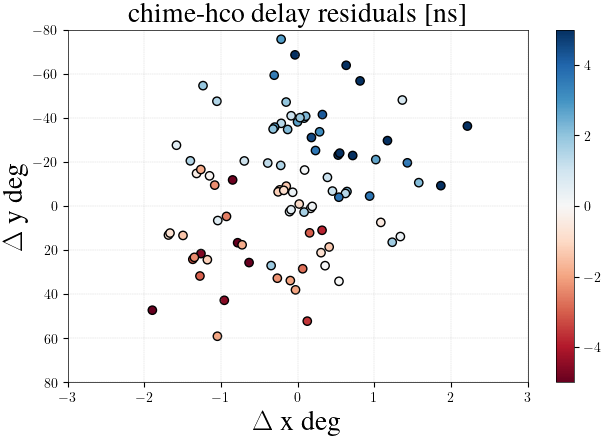

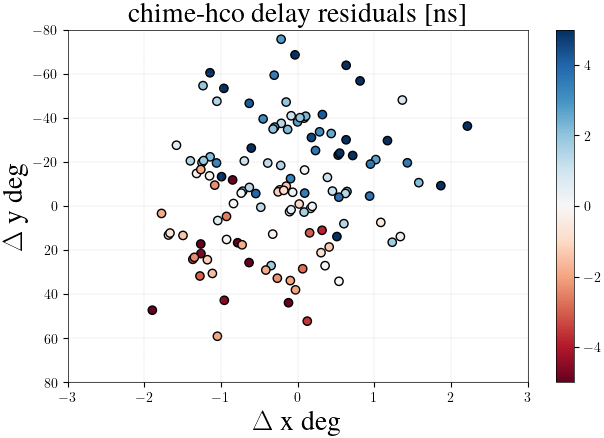

In [167]:
bad_names=np.unique(cut['A'][:])
bad_cal_names=np.unique(cut['B'][:])

vmax=5
vmin=-5
key='taus_xx'

dfx = df[~df['name'].isin(bad_names)].reset_index(drop=True)
dfx = dfx[~dfx['calibrator_source_name'].isin(bad_cal_names)].reset_index(drop=True)
im=plt.scatter(dfx['x_deg']-dfx['cal_x_deg'],dfx['y_deg']-dfx['cal_y_deg'],c=dfx[key]*1e3,edgecolor='black',cmap='RdBu',vmin=vmin,vmax=vmax)
plt.colorbar(im)
plt.ylim(80,-80)
plt.xlim(-3,3)
plt.title(f'chime-{tel} delay residuals [ns]')# (no iono fit)')
plt.xlabel(r'$\Delta$ x deg',fontsize=fontsize)
plt.ylabel(r'$\Delta$ y deg',fontsize=fontsize)
plt.show()

dfx=df
im=plt.scatter(dfx['x_deg']-dfx['cal_x_deg'],dfx['y_deg']-dfx['cal_y_deg'],c=dfx[key]*1e3,edgecolor='black',cmap='RdBu',vmin=vmin,vmax=vmax)
plt.colorbar(im)
plt.ylim(80,-80)
plt.xlim(-3,3)
plt.title(f'chime-{tel} delay residuals [ns]')# (no iono fit)')
plt.xlabel(r'$\Delta$ x deg',fontsize=fontsize)
plt.ylabel(r'$\Delta$ y deg',fontsize=fontsize)
plt.show()

### the vast majority are consistent to 2ns, so we should be able to fit the baseline offset to the ~2ns level or better with enough data

### In principle, we should always get phase closure if we model our phases perfectly.If we are not modeling our phases perfectly, the beam phase could contribute a term to the delay that messes the fit up

That is to say ax-bx=(a-b)x is always linear

But the linear contribution of (f_a(x)-f_b(x)) is not(?)

Although note that if the beam phase is strongly linear, we will get phase closure...so this actually isn't a perfect test


In [119]:
import matplotlib.pyplot as plt
i=0
j=0

A=df['name'][i]

dfA=dfA[dfA['name']==A].reset_index(drop=True)

B = dfA['calibrator_source_name'][j]

dfB=df[df['name']==B].reset_index(drop=True)



#im=plt.scatter(df['fft_taus_xx']*1e3,df['taus_xx']*1e3,c=df['tecs_xx'])#,bins=np.linspace(-10,10,100)
#plt.colorbar(im)

0      J0117+8928
1      J1126+3345
2      J1127+5650
3      J0117+8928
4      J1132+5100
          ...    
115    J1132+5100
116    J1129+5638
117    J1135+3708
118    J1153+8058
119    J1130+2157
Name: name, Length: 120, dtype: object

In [156]:
df[['name','calibrator_source_name','taus_xx']]

,name,calibrator_source_name,taus_xx
0,J0117+8928,J1127+5743,-0.00227
1,J1126+3345,J1129+5638,0.00792
2,J1127+5650,J1127+5743,-0.00094
3,J0117+8928,J1132+6324,0.00004
4,J1132+5100,J1129+5025,0.00132
...,...,...,...
115,J1132+5100,J1130+3815,-0.00026
116,J1129+5638,J1132+6324,0.00116
117,J1135+3708,J1130+2157,-0.00015
118,J1153+8058,J1129+5025,-0.00155


In [122]:
 df.keys()

Index(['file', 'fft_taus_xx', 'fft_taus_yy', 'fft_tecs_xx', 'fft_tecs_yy',
       'taus_xx', 'taus_yy', 'tecs_xx', 'tecs_yy', 'taus_no_iono_xx',
       'taus_no_iono_yy', 'x_deg', 'y_deg', 'cal_x_deg', 'cal_y_deg', 'name',
       'calibrator_source_name'],
      dtype='object')

'/arc/projects/chime_frb/vlbi/OVP_astrometry_hco_F11/trial1/436928449/calibrated/J1130+2157_calibrated_to_J1127+5650_vis.h5'


### from simulations, it seems like the only thing that can prevent phase closure is an issue with band overlap (or error propogation)


In [194]:
freqs=np.linspace(400,800,100)
def sim_data(a,poly,freqs):
    return a*freqs+poly(freqs)
    
    
# Create the polynomial p(x) = 1x^2 + 2x + 3
#coefficients = np.array([.1, 2, 30])
coefficients = np.array([1, 200, -30,20,20,10])*100
poly = np.poly1d(coefficients*10)

a=2
b=6
c=1

A=sim_data(a,poly,freqs)
B=sim_data(b,poly,freqs)
C=sim_data(c,poly,freqs)

mask=20

A_B=A-B
A_C=A-C
B_C=B-C

y=A_B
m_A_B, b = np.polyfit(freqs[:mask], y[:mask], 1)
print(f"slope for A_B=", m_A_B)

y=A_C
m_A_C, b = np.polyfit(freqs, y, 1)
print(f"slope for A_C=", m_A_C)


y=B_C
m_B_C, b = np.polyfit(freqs, y, 1)
print(f"slope for B_C=", m_B_C)


print(f"A_B-A_C-B_C", (a-b)-(a-c)+(b-c))
print(f"A_B-A_C-B_C", (m_A_B)-(m_A_C)+(m_B_C))


slope for A_B= -4.033691729323304
slope for A_C= 1.010518811881188
slope for B_C= 5.01049306930693
A_B-A_C-B_C 0.0
A_B-A_C-B_C -0.033717471897562135


In [182]:
coefficients = np.array([1, 200, -30,20,20,10])*100
poly = np.poly1d(coefficients*10)

A=sim_data(a,poly,freqs)
B=sim_data(b,poly,freqs)
C=sim_data(c,poly,freqs)


A_B=A-B
A_C=A-C
B_C=B-C

y=A_B
m_A_B, b = np.polyfit(freqs, y, 1)

y=A_C
m_A_C, b = np.polyfit(freqs, y, 1)

y=B_C
m_B_C, b = np.polyfit(freqs, y, 1)

print(f"A_B-A_C-B_C", (m_A_B)-(m_A_C)+(m_B_C))


A_B-A_C-B_C -3.3306690738754696e-16
